In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import config
from utils import imshow, show_plot
from contrastive import ContrastiveLoss
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os
from tqdm import tqdm
import config

In [2]:
# load the dataset
training_dir = config.training_dir
testing_dir = config.testing_dir
training_csv = config.training_csv
testing_csv = config.testing_csv
val_csv = config.val_csv
val_dir = config.val_dir

In [3]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):
        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
        )

    def __len__(self):
        return len(self.train_df)


In [4]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataset = SiameseDataset(
    testing_csv,
    testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

eval_dataset = SiameseDataset(
    val_csv,
    val_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

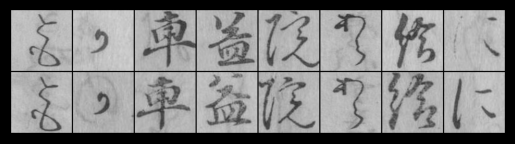

[[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]


In [6]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
class SiameseNetwork(nn.Module):
    """
        Siamese network for image similarity estimation.
        The network is composed of two identical networks, one for each input.
        The output of each network is concatenated and passed to a linear layer. 
        The output of the linear layer passed through a sigmoid function.
        `"FaceNet" <https://arxiv.org/pdf/1503.03832.pdf>`_ is a variant of the Siamese network.
        This implementation varies from FaceNet as we use the `ResNet-18` model from
        `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_ as our feature extractor.
        In addition, we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    """
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(weights=None)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.fc_in_features = self.resnet.fc.in_features
        
        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # concatenate both images' features
        output = torch.cat((output1, output2), 1)

        # pass the concatenation to the linear layers
        output = self.fc(output)

        # pass the out of the linear layers to sigmoid layer
        output = self.sigmoid(output)
        
        return output

In [11]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=config.batch_size)
eval_dataloader = DataLoader(eval_dataset, shuffle=True, batch_size=config.batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=config.batch_size)

# Declare Siamese Network
model = SiameseNetwork().to(device)
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0005)

In [21]:
# train the model
def train(model, device, optimizer, train_dataloader, epoch):
    model.train()
    criterion = nn.BCELoss()
    cum_loss = 0
    
    for batch_idx, (images_1, images_2, targets) in enumerate(train_dataloader, 0):
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
        optimizer.zero_grad()
        # output1, output2 = model(img0, img1)
        # loss_contrastive = criterion(output1, output2, label)
        # loss_contrastive.backward()
        outputs = model(images_1, images_2)
        loss = criterion(outputs, targets)
        cum_loss += loss
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images_1), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), cum_loss/batch_idx))

def eval(model, device, eval_dataloader):
    criterion = nn.BCELoss()
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for (images_1, images_2, targets) in eval_dataloader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
            outputs = model(images_1, images_2)
            test_loss += criterion(outputs, targets).sum().item()  # sum up batch loss
            pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()

    test_loss /= len(eval_dataloader.dataset)

    # for the 1st epoch, the average loss is 0.0001 and the accuracy 97-98%
    # using default settings. After completing the 10th epoch, the average
    # loss is 0.0000 and the accuracy 99.5-100% using default settings.
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(eval_dataloader.dataset),
        100. * correct / len(eval_dataloader.dataset)))


In [22]:
eval(model, device, eval_dataloader)
for epoch in tqdm(range(1, config.epochs)):
    best_eval_loss = 9999
    train(model, device, optimizer, train_dataloader, epoch)
    eval(model, device, eval_dataloader)
    print("-" * 20)
    
    # if eval_loss < best_eval_loss:
    #     best_eval_loss = eval_loss
    #     print("-" * 20)
    #     print(f"Best Eval loss{best_eval_loss}")
    #     torch.save(net.state_dict(), "/content/model.pth")
    #     print("Model Saved Successfully")



Test set: Average loss: 0.0037, Accuracy: 1759/1820 (97%)



  0%|          | 0/19 [00:00<?, ?it/s]

Train Epoch: 1 [1568/5458 (29%)]	Loss: 0.082396
Train Epoch: 1 [3168/5458 (58%)]	Loss: 0.079817
Train Epoch: 1 [4768/5458 (87%)]	Loss: 0.076994


  5%|▌         | 1/19 [00:13<04:01, 13.44s/it]


Test set: Average loss: 0.0038, Accuracy: 1747/1820 (96%)

--------------------
Train Epoch: 2 [1568/5458 (29%)]	Loss: 0.067625
Train Epoch: 2 [3168/5458 (58%)]	Loss: 0.075549
Train Epoch: 2 [4768/5458 (87%)]	Loss: 0.079900


 11%|█         | 2/19 [00:26<03:44, 13.22s/it]


Test set: Average loss: 0.0035, Accuracy: 1745/1820 (96%)

--------------------
Train Epoch: 3 [1568/5458 (29%)]	Loss: 0.060237
Train Epoch: 3 [3168/5458 (58%)]	Loss: 0.073116
Train Epoch: 3 [4768/5458 (87%)]	Loss: 0.070922


 16%|█▌        | 3/19 [00:39<03:29, 13.06s/it]


Test set: Average loss: 0.0042, Accuracy: 1735/1820 (95%)

--------------------
Train Epoch: 4 [1568/5458 (29%)]	Loss: 0.073811
Train Epoch: 4 [3168/5458 (58%)]	Loss: 0.065009
Train Epoch: 4 [4768/5458 (87%)]	Loss: 0.059512


 21%|██        | 4/19 [00:52<03:18, 13.24s/it]


Test set: Average loss: 0.0034, Accuracy: 1751/1820 (96%)

--------------------
Train Epoch: 5 [1568/5458 (29%)]	Loss: 0.062107
Train Epoch: 5 [3168/5458 (58%)]	Loss: 0.059548
Train Epoch: 5 [4768/5458 (87%)]	Loss: 0.067346


 26%|██▋       | 5/19 [01:06<03:06, 13.34s/it]


Test set: Average loss: 0.0045, Accuracy: 1743/1820 (96%)

--------------------
Train Epoch: 6 [1568/5458 (29%)]	Loss: 0.039761
Train Epoch: 6 [3168/5458 (58%)]	Loss: 0.058233
Train Epoch: 6 [4768/5458 (87%)]	Loss: 0.056196


 32%|███▏      | 6/19 [01:19<02:54, 13.40s/it]


Test set: Average loss: 0.0035, Accuracy: 1753/1820 (96%)

--------------------
Train Epoch: 7 [1568/5458 (29%)]	Loss: 0.048031
Train Epoch: 7 [3168/5458 (58%)]	Loss: 0.051851
Train Epoch: 7 [4768/5458 (87%)]	Loss: 0.058904


 37%|███▋      | 7/19 [01:33<02:40, 13.33s/it]


Test set: Average loss: 0.0041, Accuracy: 1733/1820 (95%)

--------------------
Train Epoch: 8 [1568/5458 (29%)]	Loss: 0.046781
Train Epoch: 8 [3168/5458 (58%)]	Loss: 0.043548
Train Epoch: 8 [4768/5458 (87%)]	Loss: 0.051389


 42%|████▏     | 8/19 [01:46<02:25, 13.23s/it]


Test set: Average loss: 0.0037, Accuracy: 1758/1820 (97%)

--------------------
Train Epoch: 9 [1568/5458 (29%)]	Loss: 0.050125
Train Epoch: 9 [3168/5458 (58%)]	Loss: 0.047207
Train Epoch: 9 [4768/5458 (87%)]	Loss: 0.048054


 47%|████▋     | 9/19 [01:59<02:12, 13.27s/it]


Test set: Average loss: 0.0039, Accuracy: 1758/1820 (97%)

--------------------
Train Epoch: 10 [1568/5458 (29%)]	Loss: 0.059849
Train Epoch: 10 [3168/5458 (58%)]	Loss: 0.045630
Train Epoch: 10 [4768/5458 (87%)]	Loss: 0.041746


 53%|█████▎    | 10/19 [02:12<01:58, 13.18s/it]


Test set: Average loss: 0.0050, Accuracy: 1741/1820 (96%)

--------------------
Train Epoch: 11 [1568/5458 (29%)]	Loss: 0.041715
Train Epoch: 11 [3168/5458 (58%)]	Loss: 0.037431
Train Epoch: 11 [4768/5458 (87%)]	Loss: 0.043081


 58%|█████▊    | 11/19 [02:26<01:46, 13.30s/it]


Test set: Average loss: 0.0047, Accuracy: 1740/1820 (96%)

--------------------
Train Epoch: 12 [1568/5458 (29%)]	Loss: 0.040586
Train Epoch: 12 [3168/5458 (58%)]	Loss: 0.038645
Train Epoch: 12 [4768/5458 (87%)]	Loss: 0.039130


 63%|██████▎   | 12/19 [02:39<01:32, 13.25s/it]


Test set: Average loss: 0.0039, Accuracy: 1763/1820 (97%)

--------------------
Train Epoch: 13 [1568/5458 (29%)]	Loss: 0.028821
Train Epoch: 13 [3168/5458 (58%)]	Loss: 0.027196
Train Epoch: 13 [4768/5458 (87%)]	Loss: 0.031044


 68%|██████▊   | 13/19 [02:52<01:19, 13.29s/it]


Test set: Average loss: 0.0039, Accuracy: 1759/1820 (97%)

--------------------
Train Epoch: 14 [1568/5458 (29%)]	Loss: 0.026064
Train Epoch: 14 [3168/5458 (58%)]	Loss: 0.024131
Train Epoch: 14 [4768/5458 (87%)]	Loss: 0.031950


 74%|███████▎  | 14/19 [03:06<01:06, 13.37s/it]


Test set: Average loss: 0.0041, Accuracy: 1745/1820 (96%)

--------------------
Train Epoch: 15 [1568/5458 (29%)]	Loss: 0.031852
Train Epoch: 15 [3168/5458 (58%)]	Loss: 0.026707
Train Epoch: 15 [4768/5458 (87%)]	Loss: 0.025215


 79%|███████▉  | 15/19 [03:19<00:53, 13.35s/it]


Test set: Average loss: 0.0056, Accuracy: 1762/1820 (97%)

--------------------
Train Epoch: 16 [1568/5458 (29%)]	Loss: 0.029787
Train Epoch: 16 [3168/5458 (58%)]	Loss: 0.036020
Train Epoch: 16 [4768/5458 (87%)]	Loss: 0.037799


 84%|████████▍ | 16/19 [03:33<00:40, 13.50s/it]


Test set: Average loss: 0.0040, Accuracy: 1752/1820 (96%)

--------------------
Train Epoch: 17 [1568/5458 (29%)]	Loss: 0.037285
Train Epoch: 17 [3168/5458 (58%)]	Loss: 0.029903
Train Epoch: 17 [4768/5458 (87%)]	Loss: 0.032289


 89%|████████▉ | 17/19 [03:46<00:26, 13.41s/it]


Test set: Average loss: 0.0420, Accuracy: 1339/1820 (74%)

--------------------
Train Epoch: 18 [1568/5458 (29%)]	Loss: 0.035458
Train Epoch: 18 [3168/5458 (58%)]	Loss: 0.028934
Train Epoch: 18 [4768/5458 (87%)]	Loss: 0.030352


 95%|█████████▍| 18/19 [03:59<00:13, 13.35s/it]


Test set: Average loss: 0.0038, Accuracy: 1745/1820 (96%)

--------------------
Train Epoch: 19 [1568/5458 (29%)]	Loss: 0.024310
Train Epoch: 19 [3168/5458 (58%)]	Loss: 0.028226
Train Epoch: 19 [4768/5458 (87%)]	Loss: 0.027103


100%|██████████| 19/19 [04:13<00:00, 13.33s/it]


Test set: Average loss: 0.0037, Accuracy: 1764/1820 (97%)

--------------------


In [23]:
criterion = nn.BCELoss()
model.eval()
test_loss = 0
correct = 0
    
with torch.no_grad():
        for (images_1, images_2, targets) in test_dataloader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
            outputs = model(images_1, images_2)
            test_loss += criterion(outputs, targets).sum().item()  # sum up batch loss
            pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))


Test set: Average loss: 24.2465, Accuracy: 1760/1820 (97%)



In [24]:
# Viewing the sample of images and to check whether its loading properly
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=8)
dataiter = iter(test_dataloader)

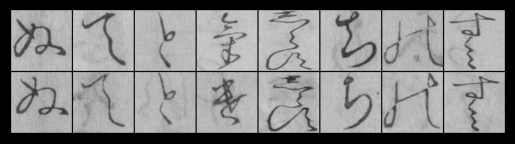

[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [25]:
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [26]:
images_1, images_2, targets = example_batch[0], example_batch[1], example_batch[2]
images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
outputs = model(images_1, images_2)
pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
correct += pred.eq(targets.view_as(pred)).sum().item()

In [28]:
outputs

tensor([[9.8928e-01],
        [4.1969e-01],
        [3.8092e-04],
        [9.9996e-01],
        [5.1286e-02],
        [9.9819e-01],
        [9.9984e-01],
        [1.2895e-04]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [27]:
pred

tensor([[1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0]], device='cuda:0')